In [1]:
import pandas as pd
import numpy as np 
import os

In [2]:
dfs = []
dfs_tmp = {}
path = "measures"
measure_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [3]:
for measure_file in measure_files:
    with open(os.path.join(path, measure_file), 'r') as f:
        key_name = measure_file[2:measure_file[2:].index("-")+2]
        if not key_name in dfs_tmp:
            dfs_tmp[key_name] = []
        if measure_file.endswith('.csv'):
            dfs_tmp[key_name].append(pd.read_csv(f))
        elif measure_file.endswith('.json'):
            dfs_tmp[key_name].append(pd.read_json(f, lines=True))

In [4]:
for key in dfs_tmp.keys():
    dfList = dfs_tmp[key]
    for df in dfList:
        df.rename(columns={'value': df.iloc[0][0][0]}, inplace=True)
    df = pd.merge(dfList[0], dfList[1], on='time')
    df = df.drop(columns=["sensor_y"])
    df["sensor_x"] = key
    df.rename(columns={'sensor_x': 'sensor'}, inplace=True)
    dfs.append(df)

# After merging the same sensor data, clean the sensor column and change header names. 
# Then concatenate all datasets in one big dataset
ds = pd.concat(dfs)
ds["T"].fillna(ds["T"].mean(), inplace=True)
ds["H"].fillna(ds["H"].mean(), inplace=True)
ds["P"].fillna(ds["P"].mean(), inplace=True)


In [5]:
ds.shape

(5384565, 5)

In [6]:
ds.head(5)

,H,P,T,sensor,time
0,31.0,1015.81464,27.0,DHT11,2017-12-22T11:22:11Z
1,31.0,1015.81464,28.0,DHT11,2017-12-22T11:22:16Z
2,31.0,1015.81464,28.0,DHT11,2017-12-22T11:22:20Z
3,31.0,1015.81464,28.0,DHT11,2017-12-22T11:22:24Z
4,31.0,1015.81464,28.0,DHT11,2017-12-22T11:22:28Z


In [7]:
ds.describe()

,H,P,T
count,5.384565e+06,5.384565e+06,5.384565e+06
mean,2.336055e+01,1.015815e+03,2.202503e+01
std,1.401280e+01,5.049089e+00,2.618106e+00
min,1.000000e+00,9.856200e+02,1.500000e+01
25%,1.000000e+00,1.015815e+03,2.067000e+01
50%,2.336055e+01,1.015815e+03,2.212000e+01
75%,3.500000e+01,1.015815e+03,2.393000e+01
max,9.990000e+01,1.040000e+03,2.980000e+01


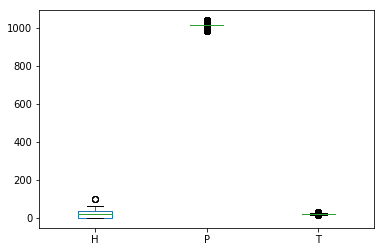

In [9]:
import matplotlib.pyplot as plt

ds.plot(kind='box')
plt.show()

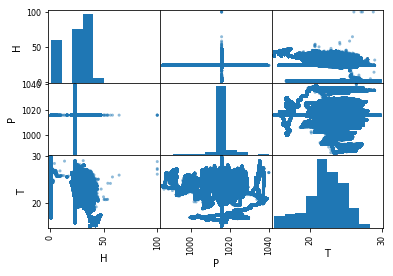

In [10]:
from pandas.plotting import scatter_matrix
scatter_matrix(ds)
plt.show()

In [11]:
import sklearn.cluster as cluster
import numpy as np
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [12]:
ds["sensor"].value_counts()

DHT22     1358057
HTU21     1346655
BMP280    1341114
DHT11     1338736
DM280           3
Name: sensor, dtype: int64

In [13]:
ds.replace({"sensor":{"DHT22":0, "HTU21":1, "BMP280": 2, "DHT11": 3, "DM280": 4}}, inplace=True)

In [14]:
ds["sensor"].value_counts()

0    1358057
1    1346655
2    1341114
3    1338736
4          3
Name: sensor, dtype: int64

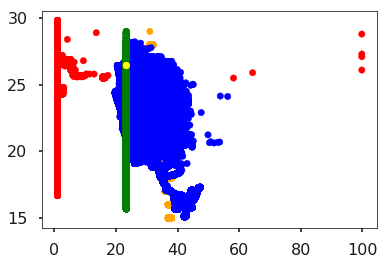

In [15]:
colors = np.array(['red','blue','green', 'orange', 'yellow'])
plt.scatter(ds['H'], ds['T'], c=colors[ds['sensor']], s=40)
plt.show()

In [16]:
model = cluster.KMeans(n_clusters=5)

In [17]:
model.fit(ds[["sensor", "T", "H", "P"]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

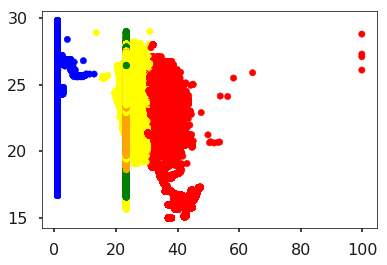

In [18]:
colors = np.array(['red','blue','green', 'orange', 'yellow'])
plt.scatter(ds['H'], ds['T'], c=colors[model.labels_], s=40)
plt.show()

In [20]:
ds.replace({"sensor":{4: "3", 3: "4", 2:"1", 1:"0", 0:"2", }}, inplace=True)
ds.replace({"sensor":{"1":1, "0":0, "2":2, "3":3, "4":4}}, inplace=True)
import sklearn.metrics 
sklearn.metrics.accuracy_score(ds['sensor'], model.labels_)

0.1854797927037746

In [22]:
sklearn.metrics.confusion_matrix(ds['sensor'],model.labels_)

array([[ 998696,       0,       0,       0,  347959],
       [      0,       0,  409150,  370105,  561859],
       [      7, 1358028,       0,       0,      22],
       [      0,       0,       3,       0,       0],
       [1338704,       0,       0,       0,      32]], dtype=int64)